# Data Preparation
This notebook details the data preparation steps for Comper.

## 1. Grab the dataset
1. Go to [https://salu133445.github.io/musegan/dataset](https://salu133445.github.io/musegan/dataset)
2. Download the `lpd-5-cleansed.tgz` dataset.
3. Extract it into a folder `lpd-5-cleansed`.
4. You should see three layers of subfolders labelled 'A'-'J', and then leaf folders named something like `TRJJFLV128F92FC46E/`, each containing a file which looks something like `c28d6d22cf7298890c5cc5f21ac2244d.npz` (this is a numpy zip file, more information [here](https://salu133445.github.io/pypianoroll/save_load.html))

## 2. Flatten all files into one folder

1. `cd` to the root of your dataset.
2. Check that there are 24474 .npz files using 
```bash
find . -mindepth 2 -type f | wc -l
```
3. Move all files to the current directory for easier access later: 
```bash
find . -mindepth 2 -type f -print -exec mv --backup=numbered {} . \;
``` 
([What?](https://askubuntu.com/questions/146634/shell-script-to-move-all-files-from-subfolders-to-parent-folder))
4. Rename all "~#~" extensions to "~#.npz" so that numpy doesn't reject the file later on.
```bash
rename 's/\~$/\.npz/' *~
```
4. Remove the empty folders `rm -r */` (Don't forget the slash!)
5. Confirm that you have the correct number of files using `ls | wc -l`.


## 3. Grab a random subset of files to play with
We'll use 100 files to start. 

In [58]:
import os, shutil
import random
import sys
import numpy as np
import pypianoroll
from matplotlib import pyplot as plt

LPD5_DIR = "/media/junshern/s_drive/FYP/MIDI/lpd_5_cleansed_copy"
DATA_DIR = "./pianorolls"
NUM_FILES = 100

In [3]:

# Create a new directory for our pianorolls
if not os.path.isdir(DATA_DIR):
    os.mkdir(DATA_DIR)
    # Grab a random subset of files from our LPD5 dataset to play with
    files_subset = random.sample(os.listdir(LPD5_DIR), NUM_FILES) # Sampling without replacement
    for filename in files_subset:
        src = os.path.join(LPD5_DIR, filename)
        dest = os.path.join(DATA_DIR, filename)
        shutil.copyfile(src, dest)
    print "Copied", NUM_FILES, "files to", DATA_DIR, "."
else:
    print "Directory already exists."

# Print the first 10 files of our chosen subset
print(os.listdir(DATA_DIR)[:10])

Directory already exists.
['825743bc60816514d61574b44abc4d22.npz', '035d2131e824eb51878007013786806a.npz', 'c7523bfd41d67de23b7e1d7575284821.npz', 'bc11aedb9c44074c732f6aac7ac9a3a3.npz.~4.npz', 'ee98ebdda35b94d0d6ba19c194db9911.npz', 'e9bfc85ab76f224f686b8a142570ab6e.npz', 'd1002f0b1b1e687baa750467113e219c.npz', '1fc99c6776860dbec8fe64dd4cc52e73.npz', '9e1d04631b8ad65addff1a9f755132aa.npz.~1.npz', 'c016f976fb71e75d8fcd931e08f64ae6.npz.~1.npz']


## 4. Inspect the data

From the MuseGAN page:

> In LPD-5, the tracks of each multi-track piano-rolls are merged into five common categories: bass, drums, piano, guitar and strings according to the program numbers provided in the MIDI files. Note that instruments out of the list are considered as part of the strings

We use [pypianoroll](https://github.com/salu133445/pypianoroll), created by the authors of MuseGAN to manipulate the data. The pypianoroll library gives us a ton of helpful methods which makes it easy to find out more about each file. (pypianoroll [docs](https://salu133445.github.io/pypianoroll/index.html))

In [33]:

def printInfo(track):
    print "\n#####################"
    print "Name: ", track.name
    print "isDrum: ", track.is_drum
    print "Program: ", track.program
    if len(track.pianoroll):
        print "Active length: ", track.get_active_length()
        print "Active pitch range: ", track.get_active_pitch_range()
    else:
        print "Empty pianoroll."
    print ""

# Pick a file to look at
filename = random.choice(os.listdir(DATA_DIR))
print(filename)
# Load pianoroll file as a multitrack object
multi = pypianoroll.Multitrack(os.path.join(DATA_DIR, filename))
print "Tempo: ", multi.tempo
print "Beat resolution: ", multi.beat_resolution
# Show some info about the pianoroll
for track in multi.tracks:
    printInfo(track)


bb352a13a60d723832075d66b5048642.npz.~1.npz
Tempo:  [90.00009 90.00009 90.00009 ... 90.00009 90.00009 90.00009]
Beat resolution:  24

#####################
Name:  Guitar
isDrum:  False
Program:  24
Active length:  9698
Active pitch range:  (49, 78)


#####################
Name:  Piano
isDrum:  False
Program:  0
Empty pianoroll.


#####################
Name:  Bass
isDrum:  False
Program:  32
Active length:  10848
Active pitch range:  (34, 44)


#####################
Name:  Drums
isDrum:  True
Program:  0
Active length:  10842
Active pitch range:  (35, 70)


#####################
Name:  Strings
isDrum:  False
Program:  48
Active length:  10812
Active pitch range:  (58, 77)



## 5. Extract pianorolls from the Piano track of all files

In [196]:
pianorolls = [] # List to hold all our piano rolls
for filename in os.listdir(DATA_DIR):
    # Load pianoroll file as a multitrack object
    multi = pypianoroll.Multitrack(os.path.join(DATA_DIR, filename))
    for track in multi.tracks:
        # Non-empty piano pianoroll
        if track.name == "Piano" and track.pianoroll.shape[0] > 0:
            pianorolls.append(track.pianoroll)
print "Complete. Number of pianorolls collected: ", len(pianorolls)

Complete. Number of pianorolls collected:  70



## 6. Create dataset for training/testing

Our model deals with predicting musical _units_ of a pianoroll, which can be for example 4 beats of a pianoroll depending on the chosen `BEATS_PER_UNIT`. The datasets we prepare must then correspond to input/output pairs of musical units.

### Model objectives

Given an input unit at time $t$, predict an output unit which may be either (depending on a user-selected prediction mode)
1. The following unit at time $t+1$
2. An accompaniment unit at time $t$
3. An accompaniment unit at time $t+1$

In the 1st case, the output is simply the _next-step prediction_, used commonly by most composition algorithms. 

In the 2nd case, the output is an _accompanying pianoroll of the current unit_, either the left-accompaniment or right-accompaniment. For example, given an input pianoroll which is a right-accompaniment, the model will be expected to predict the left-accompaniment for that input.

In the 3rd (expectedly most difficult) case, the output is an _accompanying pianoroll of the next unit_, either the left-accompaniment or right-accompaniment. For example, given an input pianoroll which is a right-accompaniment, the model will be expected to predict the left-accompaniment at the next time step.

### Unit creation

To help the model learn accompaniments, we split each pianoroll from our dataset into two complementary pianorolls which serve as accompaniments for each other. This is done in a naive way, using the `PARTITION_NOTE` as the splitting point to divide the pianoroll along the pitch axis into left- and right- accompaniments (as in left and right hand of a piano player). This approach was inspired by \[Bretan et al\]. 

Each of these pianoroll segments (of fixed tick-length and only containing notes for either left- or right- accompaniments) will be used as a single unit, and is represented by a matrix of shape `[TICKS_PER_UNIT, NUM_PITCHES=128]`. 

The input and output matrices of our model will have the same shape.

### Data structure

Since all units have the same shape, this makes it easy to store the data as a 3-dimensional matrix of depth $M$, where $M$ is the number of units (data points).

We will create 4 matrices comprising of: the input units, the next step units, the accompaniment units, and the next step accompaniment units. 

```
input_units.shape = [M, TICKS_PER_UNIT, NUM_PITCHES=128]
input_units_next.shape = [M, TICKS_PER_UNIT, NUM_PITCHES=128]
comp_units.shape = [M, TICKS_PER_UNIT, NUM_PITCHES=128]
comp_units_next.shape = [M, TICKS_PER_UNIT, NUM_PITCHES=128]
```

The unit dimension is ordered are ordered such that the $i$-th input has an output at the $i$-th element of each output matrix. (eg. given `input_units[i,:,:]`, the model should predict `input_units_next[i,:,:]`, `comp_units[i,:,:]`, or `comp_units_next[i,:,:]`)

In [195]:
# Dataset definitions
NUM_PITCHES = 128
PARTITION_NOTE = 60 # Break into left- and right-accompaniments at middle C
BEAT_RESOLUTION = 24 # This is set by the encoding of the lpd-5 dataset, corresponds to number of ticks per beat
BEATS_PER_UNIT = 4
TICKS_PER_UNIT = BEATS_PER_UNIT * BEAT_RESOLUTION


In [187]:
def chopToUnitMultiple(pianoroll, ticks_per_unit):
    """
    Given an input pianoroll matrix of shape [NUM_TICKS, NUM_PITCHES],
    truncate the matrix so that it can be evenly divided into M units.
    
    Returns [M, pianoroll_truncated]
    where M is the largest integer such that M*ticks_per_unit <= NUM_TICKS
    and pianoroll_truncated is of shape [M*ticks_per_unit, NUM_PITCHES]
    """
    
    num_ticks = pianoroll.shape[0]
    num_pitches = pianoroll.shape[1]
    
    # Get M
    M = int(num_ticks / ticks_per_unit) # Floor
    # Truncate
    pianoroll_truncated = pianoroll[:M*ticks_per_unit, :]
    
    # Debug assertions
    assert(M*ticks_per_unit <= num_ticks)
    assert(pianoroll_truncated.shape == (M*ticks_per_unit, num_pitches))
    
    return [M, pianoroll_truncated]


def shuffleLeftRight(left_units, left_units_next, right_units, right_units_next):
    """
    Given 4 matrices left, left_next, right, and right_next
    return 4 matrices which have left and right randomly exchanged
    while maintaining index order, eg:
    
    [a1,a2,a3,a4]      [a1,b2,b3,a4]
    [a2,a3,a4,a5]  ->  [a2,b3,b4,a5]
    [b1,b2,b3,b4]      [b1,a2,a3,b4]
    [b2,b3,b4,b5]      [b2,a3,a4,b5]
    """
    
    bool_array = np.random.randint(0, 2, left_units.shape[0], dtype=bool) # Random True/False
    
    # Initialize as copies of one side of the accompaniment
    input_units = left_units.copy()
    input_units_next = left_units_next.copy()
    comp_units = right_units.copy()
    comp_units_next = right_units_next.copy()

    # Replace half of array with elements from the other side
    input_units[bool_array, ...] = right_units[bool_array, ...]
    input_units_next[bool_array, ...] = right_units_next[bool_array, ...]
    comp_units[bool_array, ...] = left_units[bool_array, ...]
    comp_units_next[bool_array, ...] = left_units_next[bool_array, ...]
    
    return [input_units, input_units_next, comp_units, comp_units_next]


def create_units(pianoroll):
    """
    Given an input pianoroll matrix of shape [NUM_TICKS, NUM_PITCHES], 
    return input_units, input_units_next, comp_units, comp_units_next_shape
    all of the same shape [M, TICKS PER UNIT, NUM_PITCHES]
    """
    assert(pianoroll.shape[1] == NUM_PITCHES)
    
    # Truncate pianoroll so it can be evenly divided into units
    # Pianoroll is divided into M+1, not M 
    # since we can only get M next-units for M+1 input units
    [M_plus_one, pianoroll] = chopToUnitMultiple(pianoroll, TICKS_PER_UNIT)
    M = M_plus_one - 1
    
    # Prepare outputs
    input_units = np.zeros([M, TICKS_PER_UNIT, NUM_PITCHES])
    input_units_next = np.zeros([M, TICKS_PER_UNIT, NUM_PITCHES])
    comp_units = np.zeros([M, TICKS_PER_UNIT, NUM_PITCHES])
    comp_units_next = np.zeros([M, TICKS_PER_UNIT, NUM_PITCHES])
    
    # Split pianoroll into left- and right- accompaniments
    left_comp = pianoroll.copy()
    left_comp[:, PARTITION_NOTE:] = 0
    right_comp = pianoroll.copy()
    right_comp[:, :PARTITION_NOTE] = 0
    
    # Get the units by reshaping left_comp and right_comp
    all_left_units = left_comp.reshape(M_plus_one, TICKS_PER_UNIT, NUM_PITCHES)
    all_right_units = right_comp.reshape(M_plus_one, TICKS_PER_UNIT, NUM_PITCHES)
    left_units = all_left_units[:-1,:,:] # All but the last unit
    left_units_next = all_left_units[1:,:,:] # Skip the first unit
    right_units = all_right_units[:-1,:,:] # All but the last unit
    right_units_next = all_right_units[1:,:,:] # Skip the first unit
    
    # Randomly choose between left/right for input/comp units, 
    # so the model learns both sides of the accompaniment
    [input_units, input_units_next, comp_units, comp_units_next] = \
        shuffleLeftRight(left_units, left_units_next, right_units, right_units_next)
    
    # Debug assertions
    assert(input_units.shape == (M, TICKS_PER_UNIT, NUM_PITCHES))
    assert(input_units_next.shape == (M, TICKS_PER_UNIT, NUM_PITCHES))
    assert(comp_units.shape == (M, TICKS_PER_UNIT, NUM_PITCHES))
    assert(comp_units_next.shape == (M, TICKS_PER_UNIT, NUM_PITCHES))
    
    return [input_units, input_units_next, comp_units, comp_units_next]


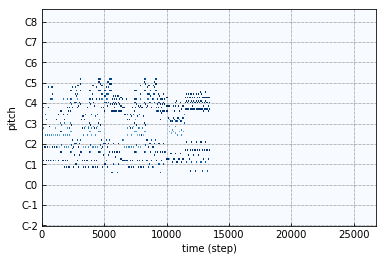

In [211]:
pianoroll = random.choice(pianorolls)
fig, ax = plt.subplots()
pypianoroll.plot_pianoroll(ax, pianoroll)


1.1403776392948142


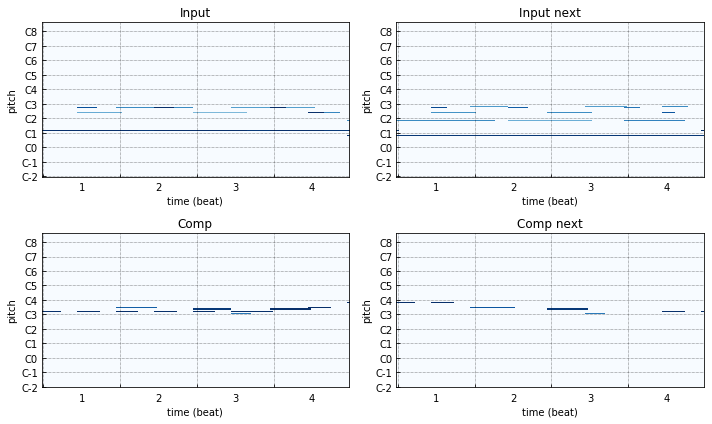

In [227]:

[input_units, input_units_next, comp_units, comp_units_next] = create_units(pianoroll)

print np.mean(input_units)
# Plot random input unit along with corresponding next and comp units
unit_index = np.random.randint(input_units.shape[0])
fig, ax = plt.subplots(2,2)
fig.set_size_inches(10, 6, forward=True)
ax[0,0].set_title('Input')
ax[0,1].set_title('Input next')
ax[1,0].set_title('Comp')
ax[1,1].set_title('Comp next')
pypianoroll.plot_pianoroll(ax[0,0], input_units[unit_index], beat_resolution=24)
pypianoroll.plot_pianoroll(ax[0,1], input_units_next[unit_index], beat_resolution=24)
pypianoroll.plot_pianoroll(ax[1,0], comp_units[unit_index], beat_resolution=24)
pypianoroll.plot_pianoroll(ax[1,1], comp_units_next[unit_index], beat_resolution=24)
fig.tight_layout()

In [235]:
import subprocess
FILEPATH = '/tmp/'
# Listen to the MIDI file
track = pypianoroll.Track(pianoroll=input_units[unit_index], program=0, is_drum=False, name='input')
multitrack = pypianoroll.Multitrack(tracks=[track], tempo=120.0, beat_resolution=24)
pypianoroll.write(multitrack, os.join(FILEPATH, 'input.midi'))
return_code = subprocess.call("timidity " + os.join(FILEPATH, 'input.midi'), shell=True)
print "Exit with code", return_code

AttributeError: 'module' object has no attribute 'join'